In [1]:
import numpy as np

In [2]:
from index_mapping import load_mapping, matrix_index_to_root_id

mapping = load_mapping('./root_id_to_index_mapping.json')
rootid_mapping = dict((v, k) for k, v in mapping.items())

In [3]:
import gzip

name_mapping = dict()

with gzip.open('./names.csv.gz', 'rt') as f:
    f.readline()
    for line in f:
        root_id, name, group = line.strip().split(',')
        root_id = int(root_id)
        name_mapping[root_id] = name

In [ ]:
import numpy as np 

cluster_assignments = np.load('cluster_assignments.npy')
cluster_scores = np.load('cluster_scores.npy')

# import torch

# cluster_assignments = torch.load("labels.pt")
# cluster_scores = torch.load("min_distances.pt")
# cluster_scores = 1./cluster_scores
# cluster_assignment_dict = np.load("cluster_assignment_dict.npy", allow_pickle=True).item()

/var/folders/mz/lh3g_k2s3qxb02pxbz15wn0r0000gn/T/ipykernel_95103/2808123134.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cluster_assignments = torch.load("labels.pt")

In [5]:
# go through each cluster, 
# fine all root_id's within that cluster,
# convert each root_id to its name,
# and list them.
clusters = np.unique(cluster_assignments)
scores = cluster_scores

for cluster in clusters:
    print(f'Cluster {cluster}')
    cluster_indices = np.where(cluster_assignments == cluster)[0]
    cluster_root_ids = [matrix_index_to_root_id(i, mapping) for i in cluster_indices]
    cluster_names = [name_mapping[root_id] for root_id in cluster_root_ids]
    # sort by scores
    cluster_names = [name for _, name in sorted(zip(scores[cluster_indices], cluster_names), reverse=True)]
    
    print(", ".join(cluster_names[:10]))

Cluster 0
ME.12972, ME.34408, EB.300, NO.232, ME.LO.14928, AL.915, ME.LO.13281, GNG.2335, ME.34244, IPS.326
Cluster 1
ME.LOP.5625, GNG.2184, ME.41537, ME.37467, ME.27962, LA.ME.552, ME.31002, LO.LOP.5919, ME.LOP.5085, LOP.2646
Cluster 2
ME.13842, ME.15698, LO.4578, LA.ME.849, ME.40825, ME.27975, ME.39066, ME.18682, LO.LOP.4827, ME.17337
Cluster 3
LA.6221, LA.4263, NO_CONS.2719, LA.2318, LA.4661, NO_CONS.3245, NO_CONS.4525, LA.360, LA.6316, NO_CONS.5065
Cluster 4
LA.2246, IPS.897, LA.2000, ME.25768, ME.28126, GNG.4507, ME.32696, NO_CONS.206, ME.31883, ME.10441
Cluster 5
ME.42649, ME.43830, GNG.4389, ME.33437, LA.ME.787, ME.15896, ME.38621, GNG.3161, SAD.384, LA.ME.34
Cluster 6
LA.2006, GNG.IPS.148, ME.LOP.5065, ME.29461, ME.24469, ME.6981, SMP.2294, ME.12392, ME.28654, ME.12359
Cluster 7
GNG.3792, ME.20353, NO_CONS.2870, ME.30984, GNG.2794, NO.225, IPS.650, ME.AOTU.204, GNG.4009, BU.1
Cluster 8
LA.803, MB_CA.MB_ML.2903, MB_CA.MB_VL.776, MB_CA.MB_ML.2978, ME.LO.3701, ME.LO.4302, PLP.MB_P

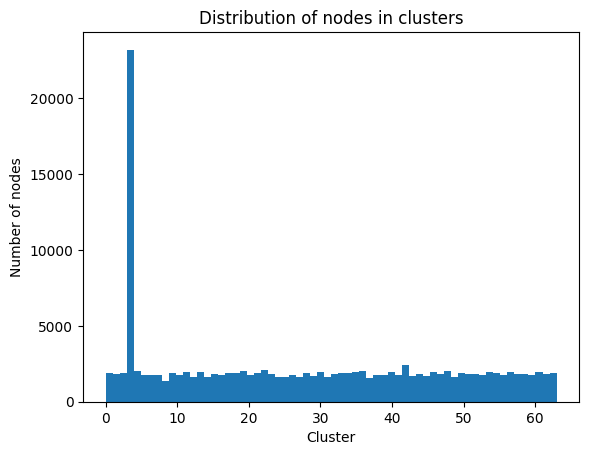

In [6]:
# draw a histogram of `cluster_assignments`
import matplotlib.pyplot as plt
plt.hist(cluster_assignments, bins=len(clusters))
plt.xlabel('Cluster')
plt.ylabel('Number of nodes')
plt.title('Distribution of nodes in clusters')
plt.show()

In [7]:
# now load the ground-truth clusters from `root_id_type_dict.pkl`
import pickle
with open('root_id_type_dict.pkl', 'rb') as f:
    root_id_type_dict = pickle.load(f)

In [8]:
# now let's see how similar the clusters are to the ground-truth clusters
from cluster_similarity_measures import compute_similarity_measures

similarity_measures = compute_similarity_measures(cluster_assignment_dict, root_id_type_dict)
for measure, value in similarity_measures.items():
    print(f"{measure}: {value}")

AxisError: axis 1 is out of bounds for array of dimension 1

In [104]:
list(cluster_assignment_dict.keys())[:5], list(root_id_type_dict.keys())[:5]

([720575940629970489,
  720575940631267655,
  720575940623828999,
  720575940612348950,
  720575940624078484],
 [720575940619787678,
  720575940618229051,
  720575940627247802,
  720575940615411161,
  720575940628209801])

In [99]:
cluster_assignment_dict

{None: tensor(4)}

/var/folders/mz/lh3g_k2s3qxb02pxbz15wn0r0000gn/T/ipykernel_68582/1289734792.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  U_posterior_mean = torch.load('U_orth.pt').cp

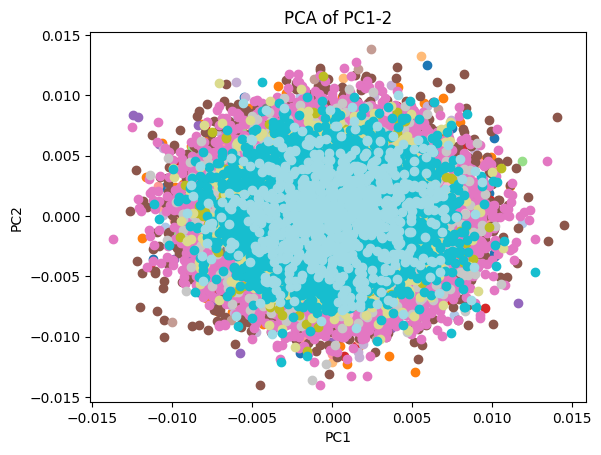

In [90]:
# load the PCA vectors from `U_posterior_mean.npy`.
# for each instance (row), get the name from `name_mapping`.
# take only the first token after splitting the name by ".". 
# find all the unique first tokens (which correspond to the group).
# color by the first token.
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

U_posterior_mean = torch.load('U_orth.pt').cpu().detach().numpy()
pca = PCA(n_components=2)
pca.fit(U_posterior_mean)

U_pca = pca.transform(U_posterior_mean)

names = [name_mapping[matrix_index_to_root_id(i, mapping)] for i in range(U_pca.shape[0])]
groups = [name.split('.')[0] for name in names]
groups = np.unique(groups)

colors = plt.cm.get_cmap('tab20', len(groups))

for i, group in enumerate(groups):
    indices = np.where([name.split('.')[0] == group for name in names])[0]
    plt.scatter(U_pca[indices, 0], U_pca[indices, 1], color=colors(i), label=group)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA of PC1-2')
plt.show()

In [86]:
groups

array(['AL', 'AME', 'AMMC', 'AOTU', 'ATL', 'AVLP', 'BU', 'CAN', 'CRE',
       'EB', 'EPA', 'FB', 'FLA', 'GA', 'GNG', 'GOR', 'IB', 'ICL', 'IPS',
       'LA', 'LAL', 'LH', 'LO', 'LOP', 'MB_CA', 'MB_ML', 'MB_PED',
       'MB_VL', 'ME', 'NO', 'NO_CONS', 'OCG', 'PB', 'PLP', 'PRW', 'PVLP',
       'SAD', 'SCL', 'SIP', 'SLP', 'SMP', 'SPS', 'UNASGD', 'VES', 'WED'],
      dtype='<U7')